In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import numpy as np
from sklearn import preprocessing
import data_process
import data_load

DATA_PATH = "../data/Turbine_Data_Penmanshiel_11_2021-01-01_-_2021-07-01_1051.csv"
LOGS_PATH = "../data/Status_Penmanshiel_11_2021-01-01_-_2021-07-01_1051.csv"

data = data_load.load_turbine_data_without_time(DATA_PATH)
logs = data_load.load_turbine_logs_with_endtime(LOGS_PATH)
labels = data_load.get_data_label(data_load.load_turbine_data(DATA_PATH), logs)
scaler = preprocessing.StandardScaler()
data = data_process.impute_data(data)
data = data_process.standardize_data(data, scaler=scaler)
print(data.shape)
data = np.array(data, dtype='float32')

(26064, 299)


In [3]:
from torch import nn
from cnn import train_model, model
from sklearn.model_selection import train_test_split

window_size = 18
X, y = data_process.split_data_into_windows(data, labels, window_size)
print(np.shape(X), np.shape(y))

epochs = 300
k = 10

i = 0
labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# X_train = X_train[y_train == 0]

cnn_model = model.CNN(feature_num=np.size(data, axis=1), window_size=window_size).to(device)
loss = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(ae_model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.015)

for epoch in range(epochs):
    print(f"\n=====epoch {epoch}/{epochs}=====")
    train_model.cnn_train(train_X=X_train, train_y=y_train, model=cnn_model, loss_fn=loss, optimizer=optimizer,
                      batch_size=1000)


(26045, 299, 18) (26045,)

=====epoch 0/300=====
loss: 0.622675  [ 1000/23440]
loss: 0.462875  [ 5000/23440]
loss: 0.324883  [ 9000/23440]
loss: 0.353156  [13000/23440]
loss: 0.287568  [17000/23440]
loss: 0.250903  [21000/23440]

=====epoch 1/300=====
loss: 0.316052  [ 1000/23440]
loss: 0.294054  [ 5000/23440]
loss: 0.264191  [ 9000/23440]
loss: 0.276449  [13000/23440]
loss: 0.211011  [17000/23440]
loss: 0.206359  [21000/23440]

=====epoch 2/300=====
loss: 0.242470  [ 1000/23440]
loss: 0.220319  [ 5000/23440]
loss: 0.212650  [ 9000/23440]
loss: 0.205672  [13000/23440]
loss: 0.177959  [17000/23440]
loss: 0.177235  [21000/23440]

=====epoch 3/300=====
loss: 0.221041  [ 1000/23440]
loss: 0.205735  [ 5000/23440]
loss: 0.208524  [ 9000/23440]
loss: 0.193925  [13000/23440]
loss: 0.174301  [17000/23440]
loss: 0.168132  [21000/23440]

=====epoch 4/300=====
loss: 0.217333  [ 1000/23440]
loss: 0.200017  [ 5000/23440]
loss: 0.205609  [ 9000/23440]
loss: 0.191171  [13000/23440]
loss: 0.172431  [17

In [4]:
from sklearn.metrics import accuracy_score, recall_score, f1_score

res = train_model.cnn_test(X_test, cnn_model)
print(np.shape(res))

softmax = nn.Softmax(dim=1)

res = softmax(res)[:,1].cpu().detach().numpy()
# res = softmax(res).cpu().detach().numpy()
# print(res)

y_pred = [1 if prob > 0.4 else 0 for prob in res]
print("accuracy:\t", accuracy_score(y_test, y_pred))
print("recall: \t", recall_score(y_test, y_pred))
print("f1:\t\t\t", f1_score(y_test, y_pred))

torch.Size([2605, 2])
accuracy:	 0.9593090211132438
recall: 	 0.4431818181818182
f1:			 0.5954198473282443


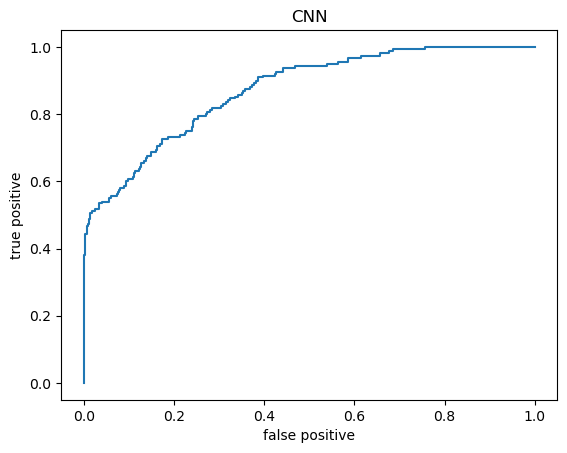

0.8714000336838954


In [5]:
from matplotlib import pyplot as plt
import sklearn.metrics as metrics

fpr, tpr, _ = metrics.roc_curve(y_test, res)

plt.plot(fpr, tpr)
plt.xlabel("false positive")
plt.ylabel("true positive")
plt.title("CNN")
plt.show()
print(metrics.auc(fpr, tpr))



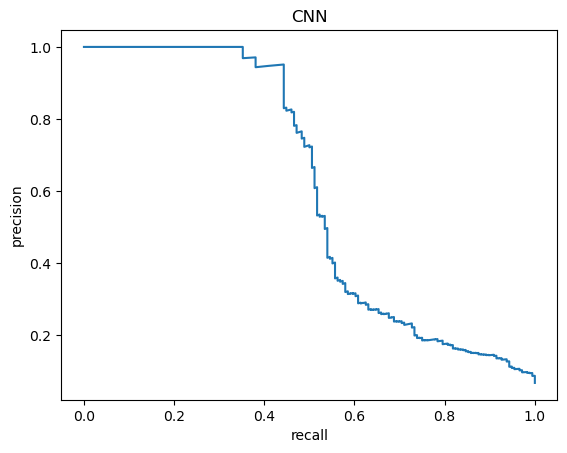

In [6]:
precision, recall, threshold = metrics.precision_recall_curve(y_test, res)
plt.plot(recall, precision)

plt.ylabel("precision")
plt.xlabel("recall")
plt.title("CNN")
plt.show()